### Load Modules

In [13]:
import sys;sys.path.append("..")
from tqdm import tqdm
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trifull/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load IMDB Review Dataset & Simple EDA

In [14]:
IMDB=pd.read_csv("../database/IMDB Dataset.csv")
IMDB

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [15]:
# NOTE: unique value가 2인 것을 통해 IMDB 데이터셋에서 감정Label(Sentiment)는 positive, negative 두가지 인 것을 알 수 있다.
print(IMDB.info())
print(IMDB.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


In [16]:
# NOTE: Class가 한쪽이 많지 않고 1:1의 비율을 갖는 (예쁜)데이터 인 것을 알 수 있다.
IMDB["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [17]:
# 데이터가 중복되는 것이 있는지 확인
# NOTE: 중복되는 entry가 있는 것을 알 수 있다. 제거 필수!!
duplicates = IMDB[IMDB.duplicated()]  
print("have duplicates:", len(duplicates) != 0)

have duplicates: True


### Data Preprocessing

In [18]:
# 중복되는 entry 제거하기.
IMDB = IMDB.drop_duplicates(subset='review') # 중복되는 행 제거
IMDB["sentiment"].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [19]:
# 긍정/부정:string을 컴퓨터가 사용할 수 있게 1/0:int으로 대응(mapping)
IMDB.loc[:, 'sentiment'] = IMDB['sentiment'].map({'positive': 1, 'negative': 0})
IMDB.loc[:, 'sentiment'].value_counts()

sentiment
1    24884
0    24698
Name: count, dtype: int64

---

In [20]:
# NOTE: 해당 feature의 value안에 순수한 문자(plain text)가 아닌 HTML의 형식이 들어간 것을 알 수 있다.
IMDB["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [21]:
# NOTE: 텍스트 데이터 전처리
# 모델의 input을 효율적으로하고 정확한 성능을 내기 위해서 텍스트데이터를 일관된 형식으로 변환하는 과정이 필요함.
# 1. 텍스트 정규화 -> "특수문자", "대/소문자", "두 칸 이상의 공백" 제거 
# 2. 자연어 처리에서 큰 의미를 가지지 않는다고 알려져 있는 불용어(stopword) 제거 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re
def clean_text(text):
    text = text.lower() # 소문자화
    text = re.sub(r"<.*?>", "", text) # HTML태그 제거 
    text = re.sub(r"[^a-z\s!?']", "", text) # 특수 문자 및 숫자 제거
    text = " ".join(word for word in text.split() if word not in stop_words) # 불용어 제거
    text = re.sub(r'\s+', ' ', text).strip() # 불필요한 공백 제거
    return text
IMDB['review_cleaned'] = IMDB['review'].apply(clean_text)
IMDB.head(3)

/tmp/ipykernel_1653500/4252996791.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB['review_cleaned'] = IMDB['review'].apply(clean_text)


,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...


BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


<Axes: ylabel='Frequency'>

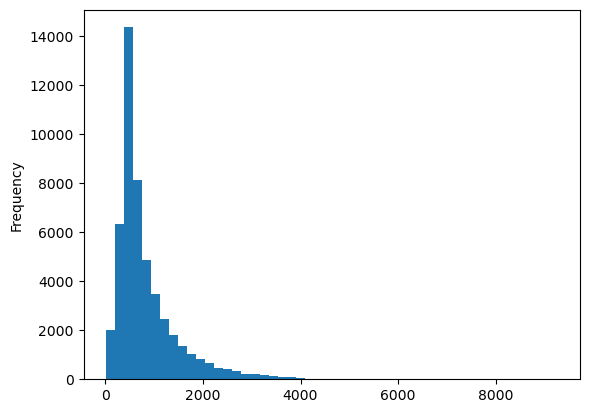

In [66]:
# Load Module,Date for Tokenize&Embedding
# https://bo-10000.tistory.com/132
# https://huggingface.co/docs/tokenizers/api/tokenizer
from modules.util import save_pkl
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
print(tokenizer)

cleaned_reviews = IMDB["review_cleaned"].to_list()
pd.Series([len(review) for review in cleaned_reviews]).plot.hist(bins=50)

In [33]:
embeded_reviews = []
for single_review in tqdm(cleaned_reviews):
    embeded_reviews.append(tokenizer.encode(single_review, truncation=True))
save_pkl("../database/tokenized.gz.pkl",embeded_reviews)

100%|██████████| 49582/49582 [01:16<00:00, 647.06it/s]


<Axes: ylabel='Frequency'>

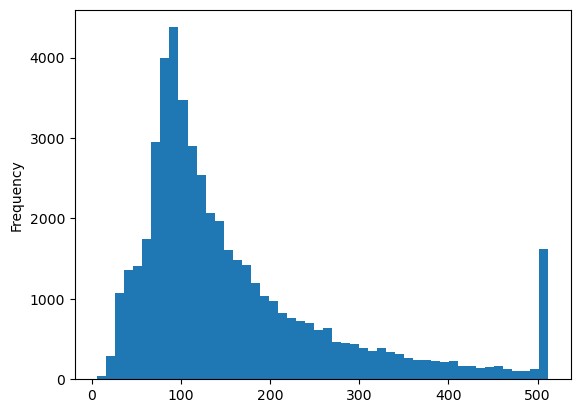

In [62]:
embeded_length_dist = pd.Series([len(em) for em in embeded_reviews])
embeded_length_dist.plot.hist(bins=50)

In [69]:
PAD, SEP, MODEL_MAX_LENGTH = 0, 102, 512
padded_token = []
for review in tqdm(embeded_reviews):
    padding_size = (MODEL_MAX_LENGTH - 1) - len(review[:-1])
    unit_review_embed = review[:-1] + [PAD] * padding_size + [SEP]
    padded_token.append(unit_review_embed)

pd.Series([len(em) for em in padded_token]).value_counts()

  0%|          | 0/49582 [00:00<?, ?it/s]

100%|██████████| 49582/49582 [00:00<00:00, 107712.47it/s]


512    49582
Name: count, dtype: int64